<a href="https://colab.research.google.com/github/Joan-yy/AnxietyLevelPrediction/blob/main/IDS_GA2_LogisticRegression_FinalVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Importing libraries

In [ ]:
# importing necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_auc_score, roc_curve, f1_score
from scipy.stats import uniform, randint
from sklearn.metrics import make_scorer
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder


## 2. Importing dataset

In [ ]:
# import dataset from google drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Year2Sem2/Dataset/enhanced_anxiety_dataset.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3. Dataset Preprocessing and Feature Engineering

In [ ]:
# Categorize anxiety levels
def map_anxiety_level(score):
    if score <= 3.0:
        return "Low"
    elif score <= 6.0:
        return "Medium"
    else:
        return "High"

df['Anxiety_Category'] = df['Anxiety Level (1-10)'].apply(map_anxiety_level)
df = df.drop(['Anxiety Level (1-10)'], axis=1, errors='ignore')

# Encode binary variables
binary_cols = ['Gender', 'Smoking', 'Family History of Anxiety', 'Dizziness', 'Medication', 'Recent Major Life Event']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

# One-hot encode Occupation
df = pd.get_dummies(df, columns=['Occupation'], drop_first=True)

# Drop rows with missing values
df = df.dropna()

# Separate features and target
X = df.drop('Anxiety_Category', axis=1)
y = df['Anxiety_Category']

# Encode target to numeric
y_encoded = y.map({'Low': 0, 'Medium': 1, 'High': 2})
class_names = ['Low', 'Medium', 'High']  # Needed for confusion matrix/ROC

## 4. Training-Testing Set Splitting
## 5. Feature Scaling

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##6. Logistic Regression Model Training

In [ ]:
# Train logistic regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Result of Original Logistic Regression Model


Accuracy: 0.7870996842580064
F1 Score: 0.8134214466449644
ROC-AUC Score: 0.9087514103004172

Classification Report:
               precision    recall  f1-score   support

         Low       0.78      0.82      0.80      1032
      Medium       0.77      0.74      0.75       961
        High       0.92      0.86      0.89       224

    accuracy                           0.79      2217
   macro avg       0.82      0.81      0.81      2217
weighted avg       0.79      0.79      0.79      2217



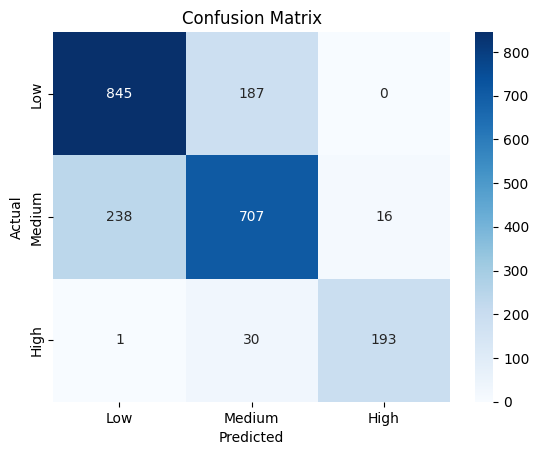

In [ ]:
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

# ROC-AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_prob = model.predict_proba(X_test_scaled)
roc_auc = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Exporting .pkl files

In [ ]:
# Save model
joblib.dump(model, 'lr_model.pkl')

# Save columns to use in Streamlit app
joblib.dump(X.columns.tolist(), 'model_features_lr.pkl')

from google.colab import files
files.download('lr_model.pkl')
files.download('model_features_lr.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 7. Hyperparameter Tuning

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}

Accuracy: 0.7866486242670275
F1 Score (Macro): 0.8130995336853731
Macro ROC-AUC Score: 0.9087568898010456

Classification Report:
               precision    recall  f1-score   support

         Low       0.78      0.82      0.80      1032
      Medium       0.76      0.74      0.75       961
        High       0.92      0.86      0.89       224

    accuracy                           0.79      2217
   macro avg       0.82      0.81      0.81      2217
weighted avg       0.79      0.79      0.79      2217



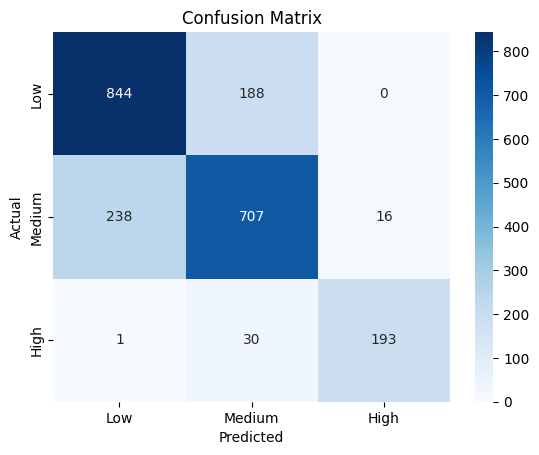

In [ ]:
# Grid search for best hyperparameters
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['lbfgs', 'saga'],   # Solvers that support multinomial
    'penalty': ['l2']              # L2 regularization
}

grid_search = GridSearchCV(
    LogisticRegression(multi_class='multinomial', max_iter=1000),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predict on test data
y_pred = best_model.predict(X_test_scaled)
y_pred_prob = best_model.predict_proba(X_test_scaled)

# Accuracy
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (Macro):", f1_score(y_test, y_pred, average='macro'))

# ROC-AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
roc_auc = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
print("Macro ROC-AUC Score:", roc_auc)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

